# **Number of Claims Estimation with Random Forest (RF)**

Random Forest is based on ensemble approach. It starts creating multiple copies of the original training data set using the bootstrap, fitting decorrelated decision tree to each copy, and then average all of trees in order to create a single predictive model. 

References:

-["Case Study: French Motor Third-Party Liability Claims"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764), Mario V. Wuthrich, Alexander Noll, Robert Salzmann;

-["Data Analytics for Non-Life Insurance Pricing"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2870308), Mario V. Wuthrich, Christoph Buser;

-["Statistical Foundations of Actuarial Learning and its Applications"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3822407), Mario V. Wuthrich, Michael Merz

# Upload Libraries

In [ ]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.2 MB 42 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.1-py2.py3-none-any.whl size=177276478 sha256=819310e153fc3d8ba6cb92614b8c98d62ebeb6730fcb722c8a0c456996d38dc1
  Stored in directory: /root/.cache/pip/wheels/a1/a1/d9/bb37df368c4635a707e7362d1088450b606041f05aeba5f173
Successfully built h2o


In [ ]:
# handling datasets
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# modelling, evaluation
import sklearn
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Upload File

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving swmotorcycle_ClaimNb.csv to swmotorcycle_ClaimNb.csv


In [ ]:
# Reading File
df = pd.read_csv('swmotorcycle_ClaimNb.csv')

# Data Set Overview

In [ ]:
# Dimensions of data set
print(df.shape)

(64548, 8)


In [ ]:
# List types for each attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64548 entries, 0 to 64547
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OwnerAge    64548 non-null  int64  
 1   Gender      64548 non-null  object 
 2   Area        64548 non-null  object 
 3   RiskClass   64548 non-null  object 
 4   VehAge      64548 non-null  int64  
 5   BonusClass  64548 non-null  object 
 6   Exposure    64548 non-null  float64
 7   ClaimNb     64548 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 3.9+ MB
None


In [ ]:
# Take a peek at the first rows of the data
df.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb
0,0,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,12,BM1,0.175342,0
1,4,Male,Lesser towns except Gotland; Northern towns,EV ratio 20-24,9,BM1,0.000000,0
2,5,Female,Lesser towns except Gotland; Northern towns,EV ratio 9-12,18,BM1,0.454795,0
3,5,Female,Small towns; countryside except Gotland; North...,EV ratio <5,25,BM1,0.172603,0
4,6,Female,Suburbs; middle-sized cities,EV ratio <5,26,BM1,0.180822,0


# Summary Statistics

In [ ]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df.columns if df[var].dtype=='object']
df[obj_cols].describe().T

,count,unique,top,freq
Gender,64548,2,Male,54695
Area,64548,7,Small towns; countryside except Gotland; North...,24816
RiskClass,64548,7,EV ratio 9-12,18905
BonusClass,64548,7,BM7,17953


In [ ]:
# Summarize attribute distributions for data type of variables
no_obj_cols = [var for var in df.columns if df[var].dtype!='object']
df[no_obj_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,64548.0,42.416062,12.980960,0.0,31.000000,44.000000,52.0,92.00000
VehAge,64548.0,12.540063,9.727445,0.0,5.000000,12.000000,16.0,99.00000
Exposure,64548.0,1.010671,1.307424,0.0,0.463014,0.827397,1.0,31.33973
ClaimNb,64548.0,0.010798,0.107323,0.0,0.000000,0.000000,0.0,2.00000


# Data Cleaning

In [ ]:
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

[]
(64548, 8)


In [ ]:
# get number of unique values for each row
counts = df.duplicated()
# record rows to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
print(df.shape)

[]
(64548, 8)


In [ ]:
# Check missing values both to numeric features and categorical features 
missing = df.isnull().sum()/df.shape[0]*100
missing

OwnerAge      0.0
Gender        0.0
Area          0.0
RiskClass     0.0
VehAge        0.0
BonusClass    0.0
Exposure      0.0
ClaimNb       0.0
dtype: float64

In [ ]:
# Feature transformation
df_1 = df.copy()
df_1['Exposure'] = df_1['Exposure'].clip(upper=1)
df_1['VehAge'] = df_1['VehAge'].clip(upper=20)

# Pre-Processing

In [ ]:
# Split dataset
df_train, df_test, = train_test_split(df_1, train_size=0.8, test_size=0.2,random_state=0)

In [ ]:
h2o.init(nthreads=-1,max_mem_size = "12G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpl4_s1wuq
  JVM stdout: /tmp/tmpl4_s1wuq/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpl4_s1wuq/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_unknownUser_qh9xg4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Convert Pandas data frame into H2O data frame
train = h2o.H2OFrame(df_train)
test = h2o.H2OFrame(df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Input 
predictors = ['Gender','RiskClass','Area','BonusClass','OwnerAge','VehAge']
# Output 
response = 'ClaimNb'

# Modelling 1

In [ ]:
# Define model
RF_model_1 = H2ORandomForestEstimator(nfolds=5, categorical_encoding='auto',seed=0)

# Train model
RF1 = RF_model_1.train(x=predictors, y=response, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [ ]:
# summary of the model
print(RF1)

Model Details
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1665114153686_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          654639                 20           20           20            810           1175          1048.42

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.012208122107316383
RMSE: 0.11049037110679094
MAE: 0.021106244462155924
RMSLE: 0.07742483856730378
Mean Residual Deviance: 0.012208122107316383

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.011881435875425285
RMSE: 0.10900199941021856
MAE: 0.021024125135344917
RMSLE: 0.07591583246446397
Mean Residual Deviance: 0

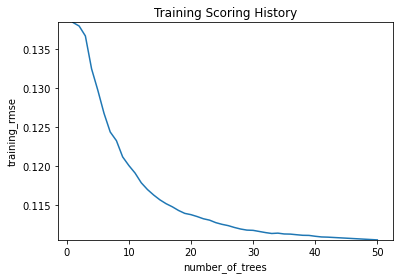

In [ ]:
# plot training history
RF1.plot()

# Model Evaluation 1

In [ ]:
# Eval performance:
perf_train_1 = RF1.model_performance(train)
pred_train_1 = RF1.predict(train)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_train_1

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.0038952520166232246
RMSE: 0.0624119541163648
MAE: 0.01197298075103173
RMSLE: 0.03846922024303165
Mean Residual Deviance: 0.0038952520166232246

In [ ]:
# Eval performance:
perf_test_1 = RF1.model_performance(test)
pred_test_1 = RF1.predict(test)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_test_1

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.013406599523944985
RMSE: 0.11578687112080102
MAE: 0.02162454584878229
RMSLE: 0.07971194339012239
Mean Residual Deviance: 0.013406599523944985

In [ ]:
# replace H2O data frame with a pandas data frame
predictions_tr_1 = pred_train_1.as_data_frame()
predictions_te_1 = pred_test_1.as_data_frame()

In [ ]:
mean_tr_1 = predictions_tr_1.mean()
mean_te_1 = predictions_te_1.mean()

In [ ]:
# replaced 0 values with the mean because "mean poisson deviance" is strictly positive 
predictions_tr_1 = predictions_tr_1.replace(0, mean_tr_1)
predictions_te_1 = predictions_te_1.replace(0, mean_te_1)


In [ ]:
mean_poisson_deviance(df_train.ClaimNb,predictions_tr_1)

0.022524642402523044

In [ ]:
mean_poisson_deviance(df_test.ClaimNb,predictions_te_1)

0.119084424849399

In [ ]:
np.sqrt(mean_squared_error(df_train.ClaimNb, predictions_tr_1))

0.06260576388501801

In [ ]:
np.sqrt(mean_squared_error(df_test.ClaimNb, predictions_te_1))

0.11577663175151649

# Modelling 2

In [ ]:
# Input 
predictors_ = ['RiskClass','Area','BonusClass','OwnerAge','VehAge']

In [ ]:
# Define model
RF_model_2 = H2ORandomForestEstimator(nfolds=5, categorical_encoding='auto',seed=0)

# Train model
RF2 = RF_model_2.train(x=predictors_, y=response, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [ ]:
# summary of the model
print(RF2)

Model Details
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1665114153686_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          210501                 13           20           18.2          104           549           333.04

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.011181817092762307
RMSE: 0.1057441113857519
MAE: 0.020656710629440866
RMSLE: 0.07184584223172084
Mean Residual Deviance: 0.011181817092762307

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.011150953331662208
RMSE: 0.10559807446948173
MAE: 0.020589260545475163
RMSLE: 0.0716674127561448
Mean Residual Deviance: 0.01

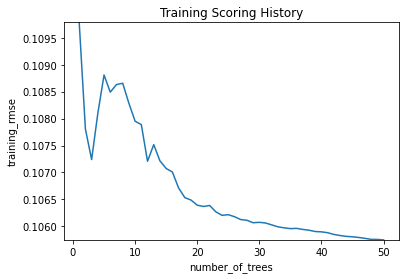

In [ ]:
# plot training history
RF2.plot()

# Model evaluation 2

In [ ]:
# Eval performance:
perf_train_2 = RF2.model_performance(train)
pred_train_2 = RF2.predict(train)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_train_2

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.009550202855421488
RMSE: 0.09772513932157624
MAE: 0.01917608960927139
RMSLE: 0.06440842260317159
Mean Residual Deviance: 0.009550202855421488

In [ ]:
# Eval performance:
perf_test_2 = RF2.model_performance(test)
pred_test_2 = RF2.predict(test)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_test_2

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.012699196919204632
RMSE: 0.11269071354466006
MAE: 0.021804859204337133
RMSLE: 0.07582426095997462
Mean Residual Deviance: 0.012699196919204632

In [ ]:
# replace H2O data frame with a pandas data frame
predictions_tr_2 = pred_train_2.as_data_frame()
predictions_te_2 = pred_test_2.as_data_frame()

In [ ]:
mean_poisson_deviance(df_train.ClaimNb,predictions_tr_2)

0.054416544080182296

In [ ]:
mean_poisson_deviance(df_test.ClaimNb,predictions_te_2)

0.0978320983223067

In [ ]:
np.sqrt(mean_squared_error(df_train.ClaimNb, predictions_tr_2))

0.09772513932157607

In [ ]:
np.sqrt(mean_squared_error(df_test.ClaimNb, predictions_te_2))

0.11269071354465993

# Modelling 3

In [ ]:
train_, valid = train.split_frame(ratios = [0.9], seed = 0)

In [ ]:
# define range of hyper-params for the grid search
rf_params = {'ntrees':[50,100],
                'mtries':[1,2]}


In [ ]:
# set up the grid search and define the model
RF_model_tuning = H2OGridSearch(H2ORandomForestEstimator(nfolds=5, categorical_encoding='auto',seed=0),
                           grid_id ='RF_model_tuning',
                           hyper_params = rf_params)


In [ ]:
# Train model
RFTuning = RF_model_tuning.train(x=predictors_, y=response, training_frame=train_, validation_frame=valid)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Get the grid results, sorted by validation Mean Residual Deviance
RF_gridperf = RFTuning.get_grid(sort_by='residual_deviance', decreasing=False)
RF_gridperf

,mtries,ntrees,model_ids,residual_deviance
,1.0,100.0,RF_model_tuning_model_3,0.0111455
,1.0,50.0,RF_model_tuning_model_1,0.0111572
,2.0,100.0,RF_model_tuning_model_4,0.0123602
,2.0,50.0,RF_model_tuning_model_2,0.0124465


In [ ]:
# Define model
RF_model_3 = H2ORandomForestEstimator(ntrees = 100, mtries = 1, nfolds=5, categorical_encoding='auto',seed=0)

# Train model
RF3 = RF_model_3.train(x=predictors_, y=response, training_frame=train_, validation_frame=valid)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [ ]:
# summary of the model
print(RF3)

Model Details
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1665114153686_3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         401435                 12           20           17.62         56            540           317.3

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.01114815103116971
RMSE: 0.10558480492556545
MAE: 0.020427555910122453
RMSLE: 0.07154591702277245
Mean Residual Deviance: 0.01114815103116971

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.011109271646632064
RMSE: 0.10540052963164874
MAE: 0.020545476433270937
RMSLE: 0.07237865211670227
Mean Residual Deviance: 0.011109271

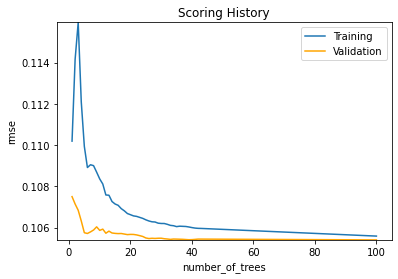

In [ ]:
# plot training history
RF3.plot()

# Model Evaluation 3

In [ ]:
# Eval performance:
perf_train_3 = RF3.model_performance(train)
pred_train_3 = RF3.predict(train)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_train_3

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.009576148435712082
RMSE: 0.09785779701031534
MAE: 0.019031707231795873
RMSLE: 0.06457561622960956
Mean Residual Deviance: 0.009576148435712082

In [ ]:
# Eval performance:
perf_test_3 = RF3.model_performance(test)
pred_test_3 = RF3.predict(test)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_test_3

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.012729059271545974
RMSE: 0.11282313269691625
MAE: 0.0216530820054663
RMSLE: 0.07594458537265546
Mean Residual Deviance: 0.012729059271545974

In [ ]:
# replace H2O data frame with a pandas data frame
predictions_tr_3 = pred_train_3.as_data_frame()
predictions_te_3 = pred_test_3.as_data_frame()

In [ ]:
mean_poisson_deviance(df_train.ClaimNb,predictions_tr_3)

0.05607403684705855

In [ ]:
mean_poisson_deviance(df_test.ClaimNb,predictions_te_3)

0.09821357076698017

In [ ]:
np.sqrt(mean_squared_error(df_train.ClaimNb, predictions_tr_3))

0.0978577970103157

In [ ]:
np.sqrt(mean_squared_error(df_test.ClaimNb, predictions_te_3))

0.11282313269691602

# **RF Results Analysis**

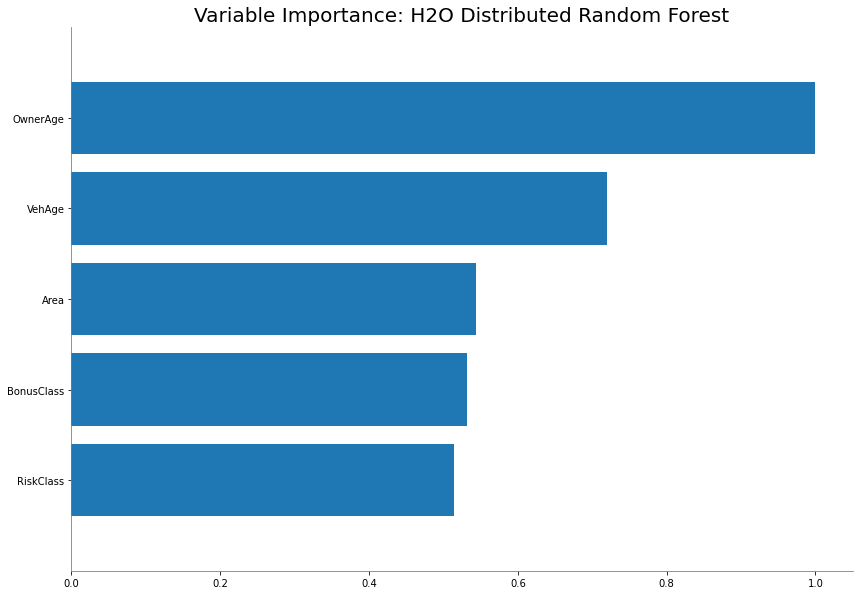

<Figure size 432x288 with 0 Axes>

In [ ]:
# Feature Importance
RF2.varimp_plot()

In [ ]:
predictions_te_2 = predictions_te_2.rename(columns = {'predict':'ClaimNb_pred'})
test = pd.concat([df_test, predictions_te_2.set_index(df_test.index)], axis=1)
test

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimNb_pred
11551,28,Female,Small towns; countryside except Gotland; North...,EV ratio 20-24,13,BM3,0.419178,0,0.024548
27696,42,Female,Suburbs; middle-sized cities,EV ratio <5,4,BM7,0.983562,0,0.012590
56213,57,Male,Lesser towns except Gotland; Northern towns,EV ratio 13-15,16,BM7,1.000000,0,0.004977
8463,26,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,13,BM1,0.986301,0,0.012411
35448,45,Male,Small towns; countryside except Gotland; North...,EV ratio 20-24,4,BM6,0.986301,0,0.005993
...,...,...,...,...,...,...,...,...,...
15776,31,Female,Lesser towns except Gotland; Northern towns,EV ratio 13-15,15,BM7,0.989041,0,0.006424
43435,49,Male,Small towns; countryside except Gotland; North...,EV ratio 13-15,11,BM7,1.000000,0,0.008657
50162,53,Male,Suburbs; middle-sized cities,EV ratio 9-12,6,BM7,1.000000,0,0.012358
2912,22,Male,Suburbs; middle-sized cities,EV ratio 16-19,8,BM1,0.630137,0,0.018697


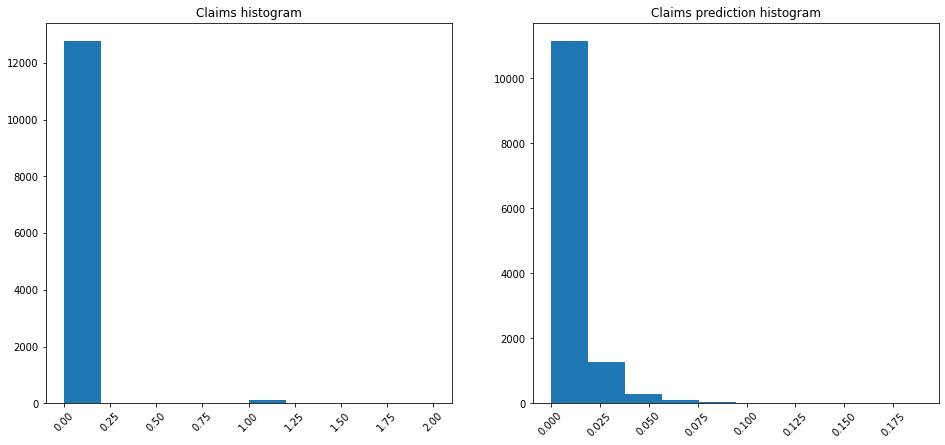

In [ ]:
# Claims comparison
fig = plt.figure(figsize = (16,7))
plt.subplot(1,2,1)  
plt.hist(test['ClaimNb'], bins=10)
plt.xticks(rotation=45)
plt.title('Claims histogram')
plt.subplot(1,2,2)  
plt.hist(test['ClaimNb_pred'], bins=10)
plt.xticks(rotation=45)
plt.title('Claims prediction histogram')
plt.show()

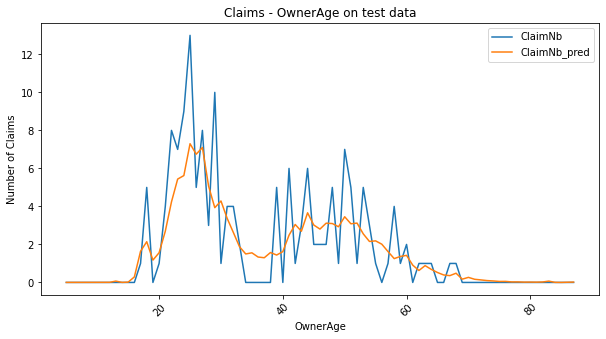

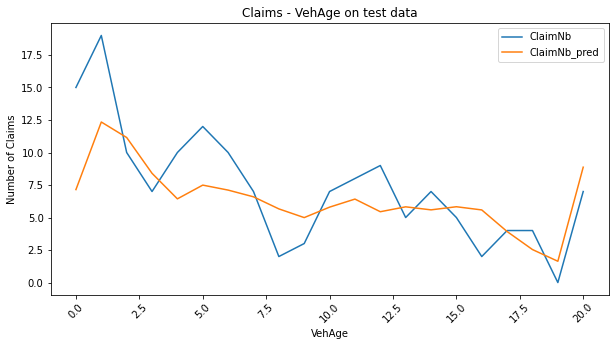

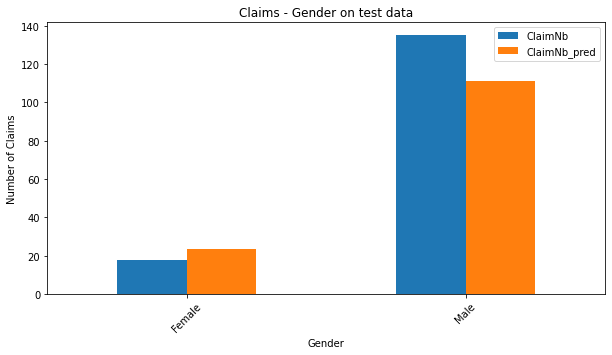

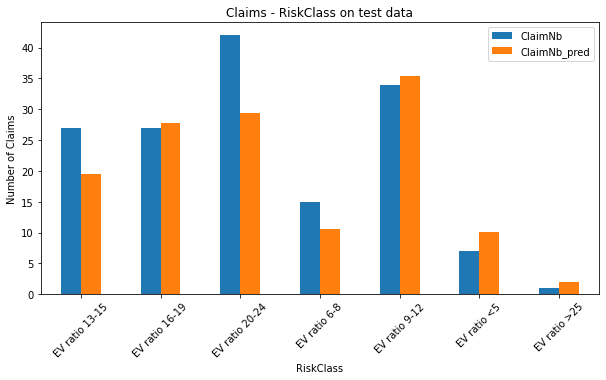

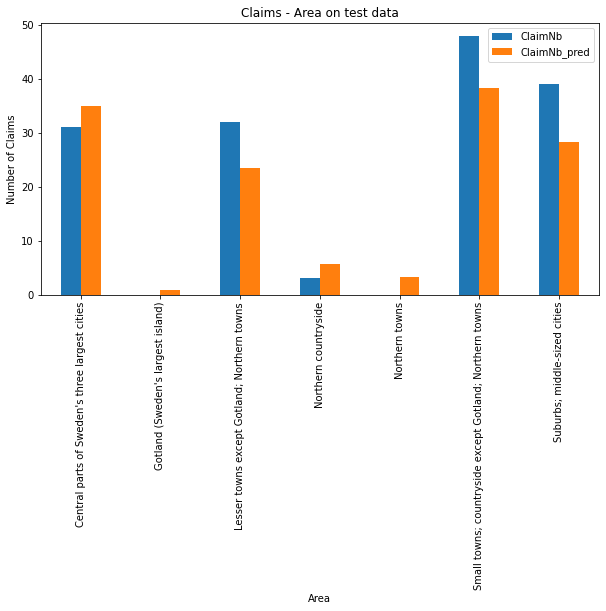

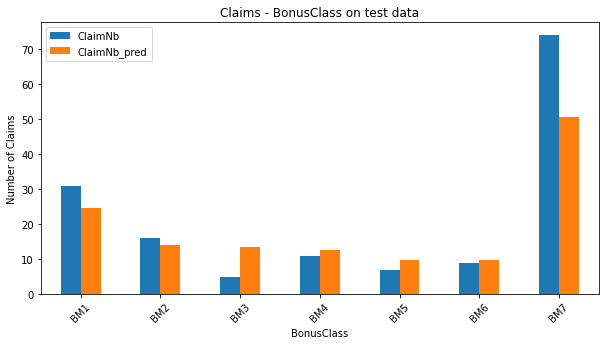

In [ ]:
# Claims and claims predicted comparison on features
plt.rcParams["figure.figsize"] = (10,5)
test_group_oa = test.groupby(['OwnerAge'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_oa.plot(x='OwnerAge',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('OwnerAge')
plt.title('Claims - OwnerAge on test data')
plt.show()
test_group_va = test.groupby(['VehAge'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_va.plot(x='VehAge',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('VehAge')
plt.title('Claims - VehAge on test data')
plt.show()
test_group_ge = test.groupby(['Gender'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_ge.plot.bar(x='Gender',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('Gender')
plt.title('Claims - Gender on test data')
plt.show()
test_group_rc = test.groupby(['RiskClass'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_rc.plot.bar(x='RiskClass',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('RiskClass')
plt.title('Claims - RiskClass on test data')
plt.show()
test_group_a = test.groupby(['Area'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_a.plot.bar(x='Area',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=90)
plt.ylabel('Number of Claims')
plt.xlabel('Area')
plt.title('Claims - Area on test data')
plt.show()
test_group_bc = test.groupby(['BonusClass'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_bc.plot.bar(x='BonusClass',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('BonusClass')
plt.title('Claims - BonusClass on test data')
plt.show()
